# MLP with GroupKFold(10) + Per-fold Optuna Tuning

- Create 10 spatial clusters (KMeans on lon/lat)
- Use GroupKFold(10) with those clusters
- For each fold: tune MLP hyperparameters on train/val via Optuna, fit best, predict test
- Average fold test predictions; compute OOF RMSE
- Optional: linear bias correction y = a + b·ŷ using OOF
- Save Kaggle submission (id,rh98)


In [1]:
# %pip install -q numpy pandas scikit-learn optuna seaborn matplotlib
import os, re, json, math
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

sns.set(context='notebook', style='whitegrid', palette='deep')

RANDOM_STATE = 42
N_SPLITS = 10
N_JOBS = -1

BASE_DIR = Path('/Users/yohan/Documents/GitHub/OpenGeoHub_2025')
TRAIN_PATH = BASE_DIR / 'train.csv'
TEST_PATH  = BASE_DIR / 'test.csv'


Train: (39535, 67) Test: (19745, 65)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


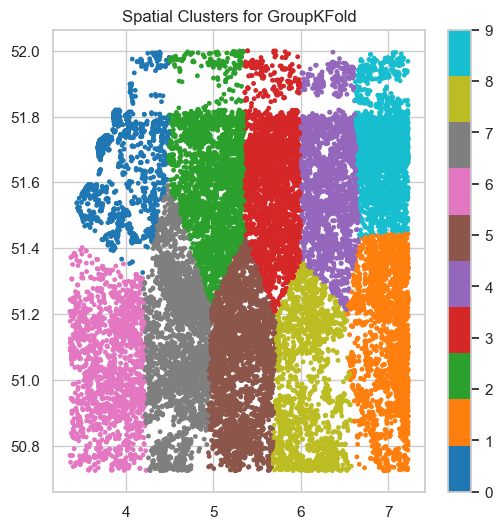

In [2]:
def rmse_cm(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
print('Train:', train.shape, 'Test:', test.shape)

# Spatial clusters
coords = train[['lon', 'lat']].values
kmeans = KMeans(n_clusters=N_SPLITS, random_state=RANDOM_STATE, n_init='auto')
train['spatial_cluster'] = kmeans.fit_predict(coords)

# Features (exclude target and coords and group)
features = [c for c in train.columns if c not in ['rh98','lon','lat','spatial_cluster']]
X = train[features]
y = train['rh98'].astype(float).values
X_test = test[features]

# Visual checks (optional)
plt.figure(figsize=(6,6))
sc = plt.scatter(train['lon'], train['lat'], c=train['spatial_cluster'], cmap='tab10', s=6)
plt.colorbar(sc)
plt.title('Spatial Clusters for GroupKFold')
plt.show()


In [3]:
# Optuna objective function for a fold

def objective(trial, X_tr, y_tr, X_va, y_va):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(128,), (256,), (256,128), (512,256)]),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'learning_rate_init': trial.suggest_categorical('learning_rate_init', [1e-4, 3e-4, 1e-3, 3e-3]),
        'batch_size': trial.suggest_categorical('batch_size', [128, 256, 512])
    }
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            alpha=params['alpha'],
            learning_rate_init=params['learning_rate_init'],
            batch_size=params['batch_size'],
            activation='relu', solver='adam',
            early_stopping=True, max_iter=500, random_state=RANDOM_STATE
        ))
    ])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_va)
    return rmse_cm(y_va, preds)

# Per-fold tuning
predicted = []
oof = np.zeros(len(y))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

gkf = GroupKFold(n_splits=N_SPLITS)
for i, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=train['spatial_cluster'])):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    study.optimize(lambda t: objective(t, X_tr, y_tr, X_va, y_va), n_trials=5, n_jobs=1)
    best_params = study.best_params

    final_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(
            hidden_layer_sizes=best_params['hidden_layer_sizes'],
            alpha=best_params['alpha'],
            learning_rate_init=best_params['learning_rate_init'],
            batch_size=best_params['batch_size'],
            activation='relu', solver='adam', early_stopping=True, max_iter=500,
            random_state=RANDOM_STATE
        ))
    ])
    final_pipe.fit(X_tr, y_tr)

    # OOF for this fold
    oof[va_idx] = final_pipe.predict(X_va)

    # Test predictions for this fold
    predicted.append(final_pipe.predict(X_test))
    print(f"Fold {i+1} best params: {best_params}")

# OOF RMSE
oof_rmse = rmse_cm(y, oof)
print('OOF RMSE (cm):', round(oof_rmse, 2))

# Average fold test predictions
final_pred = np.mean(np.vstack(predicted), axis=0)
print('final_pred shape:', final_pred.shape)


[I 2025-09-02 21:23:15,700] A new study created in memory with name: no-name-8ce5c296-00f3-4f14-a306-74c4f9c06366
/opt/homebrew/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
/opt/homebrew/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256,) which is of type tuple.
  warnings.warn(message)
/opt/homebrew/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
/opt/homebrew/lib/python3.11/site-packages/optuna/distributions.py:518: UserWa

Fold 1 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 3.0771802712506896e-06, 'learning_rate_init': 0.001, 'batch_size': 128}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 2 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 0.005233480488540089, 'learning_rate_init': 0.001, 'batch_size': 256}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 3 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 0.005233480488540089, 'learning_rate_init': 0.001, 'batch_size': 256}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 4 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 0.005233480488540089, 'learning_rate_init': 0.001, 'batch_size': 256}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 5 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 7.268270012959542e-05, 'learning_rate_init': 0.001, 'batch_size': 256}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 6 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 7.268270012959542e-05, 'learning_rate_init': 0.001, 'batch_size': 256}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 7 best params: {'hidden_layer_sizes': (256, 128), 'alpha': 0.00017550670310904077, 'learning_rate_init': 0.001, 'batch_size': 256}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 8 best params: {'hidden_layer_sizes': (128,), 'alpha': 0.0005336071368923619, 'learning_rate_init': 0.003, 'batch_size': 512}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 9 best params: {'hidden_layer_sizes': (128,), 'alpha': 0.0005336071368923619, 'learning_rate_init': 0.003, 'batch_size': 512}


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

Fold 10 best params: {'hidden_layer_sizes': (128,), 'alpha': 0.0005336071368923619, 'learning_rate_init': 0.003, 'batch_size': 512}
OOF RMSE (cm): 542.21
final_pred shape: (19745,)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.11/site-

In [4]:
# Bias correction on OOF and Kaggle submission
lr = LinearRegression().fit(oof.reshape(-1,1), y)
a, b = float(lr.intercept_), float(lr.coef_[0])
print(f"Bias correction: a={a:.2f} cm, b={b:.4f}")

final_pred_bias = a + b * final_pred

# Save predictions
pd.DataFrame({'pred_cm': final_pred, 'pred_cm_bias_corrected': final_pred_bias}).to_csv(
    BASE_DIR / 'test_predictions_mlp_optuna_foldwise.csv', index=False
)

# Kaggle submission (id,rh98)
assert 'id' in test.columns, "Expected 'id' column in test.csv"
submission = pd.DataFrame({'id': test['id'], 'rh98': final_pred_bias})
SUB_PATH = BASE_DIR / 'submission_kaggle_mlp_optuna_foldwise.csv'
submission.to_csv(SUB_PATH, index=False)
print('Saved Kaggle submission to:', SUB_PATH)


Bias correction: a=52.30 cm, b=0.9749
Saved Kaggle submission to: /Users/yohan/Documents/GitHub/OpenGeoHub_2025/submission_kaggle_mlp_optuna_foldwise.csv
